In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import math
import random
import sys
from timesformer_pytorch import TimeSformer
from collections import defaultdict

In [3]:
ucfPath = 'D:/Files/Datasets/UCF-101'
ucfTestSplitPath = 'D:/Files/Datasets/ucfTrainTestlist/testlist01.txt'
#ucfPath = 'UCF-101'
framesPerVideo = 8
maxVideoPerClass = 11
maxClasses = 101
valPerClass = 10
numEpochs = 20
embeddingsSize = 256
batchSize = 1

In [4]:
class AdvancedTimeSformer(TimeSformer):
    def __init__(
        self,
        *,
        dim,
        num_frames,
        num_classes,
        image_width = 320,
        image_height = 240,
        patch_size = 16,
        channels = 3,
        depth = 12,
        heads = 8,
        dim_head = 64,
        attn_dropout = 0.,
        ff_dropout = 0.
    ):
        super().__init__(dim = dim, 
                         num_frames = num_frames, 
                         num_classes = num_classes, 
                         image_width = image_width, 
                         image_height = image_height,
                         patch_size = patch_size,
                         channels = channels, 
                         depth = depth,
                         heads = heads,
                         dim_head = dim_head,
                         attn_dropout = attn_dropout,
                         ff_dropout = ff_dropout)
        self.to_out = torch.nn.Sequential(
            torch.nn.LayerNorm(dim),
            torch.nn.Linear(dim, num_classes),
            #torch.nn.Softmax(num_classes)
        )

In [5]:
'''class DataStorage():
    def __init__(self, ucfDataPath, framesPerVideo, ucfSplitNumber = 1, maxVideoPerClass = None, maxClasses = None):
        
        ucfFullSize = 13320
        self.trainLabelsNames = {}
        lastTrainIndex = 0
        lastTestIndex = 0
        
        self.trainDict = defaultdict(list)
        self.testDict = defaultdict(list)
        if maxVideoPerClass is None:
            self.trainData = np.zeros((ucfFullSize - 101 * valPerClass, framesPerVideo, 3, 240, 320), dtype=np.uint8)
            self.trainLabels = np.zeros((ucfFullSize - 101 * valPerClass), dtype=int)
            self.testData = np.zeros((101 * valPerClass, framesPerVideo, 3, 240, 320), dtype=np.uint8)
            self.testLabels = np.zeros((101 * valPerClass), dtype=int)
        else:
            if maxClasses is None:
                self.trainData = np.zeros((101 * (maxVideoPerClass - valPerClass), framesPerVideo, 3, 240, 320), dtype=np.uint8)
                self.trainLabels = np.zeros((101 * (maxVideoPerClass - valPerClass)), dtype=int)
                self.testData = np.zeros((101 * valPerClass, framesPerVideo, 3, 240, 320), dtype=np.uint8)
                self.testLabels = np.zeros((101 * valPerClass), dtype=int)
            else:
                self.trainData = np.zeros((maxClasses * (maxVideoPerClass - valPerClass), framesPerVideo, 3, 240, 320), dtype=np.uint8)
                self.trainLabels = np.zeros((maxClasses * (maxVideoPerClass - valPerClass)), dtype=int)
                self.testData = np.zeros((maxClasses * valPerClass, framesPerVideo, 3, 240, 320), dtype=np.uint8)
                self.testLabels = np.zeros((maxClasses * valPerClass), dtype=int)                
        
        for k, classFolderName in enumerate(sorted(os.listdir(ucfPath))):
            if maxClasses is not None and k >= maxClasses:
                break
            
            print('Process class ' + classFolderName)
            self.trainLabelsNames[classFolderName] = k
            for i, videoName in enumerate(sorted(os.listdir(os.path.join(ucfPath, classFolderName)))):
                if maxVideoPerClass is not None and i >= maxVideoPerClass:
                    break

                if i < valPerClass:
                    self.testLabels[lastTestIndex] = k
                    self.testDict[k].append(lastTestIndex)
                else:
                    self.trainLabels[lastTrainIndex] = k
                    self.trainDict[k].append(lastTrainIndex)

                count = 0
                video = cv2.VideoCapture(os.path.join(ucfPath, classFolderName, videoName))
                numberOfFrames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

                for j in range(framesPerVideo):
                    video.set(cv2.CAP_PROP_POS_FRAMES, count)
                    success, image = video.read()
                    if success:
                        if image.shape != (240, 320, 3):
                            image = cv2.resize(image, (320, 240))
                        if i < valPerClass:
                            self.testData[lastTestIndex][j] = np.swapaxes(
                                                np.swapaxes(image, 
                                                    0, 2),
                                                1, 2)
                        else:
                            self.trainData[lastTrainIndex][j] = np.swapaxes(
                                                np.swapaxes(image, 
                                                    0, 2),
                                                1, 2)
                    count += numberOfFrames // framesPerVideo
                    
                if i < valPerClass:
                    lastTestIndex += 1
                else:
                    lastTrainIndex += 1
            
        assert lastTrainIndex == self.trainData.shape[0], "Error in train data length"
        assert lastTestIndex == self.testData.shape[0], "Error in test data length"
        '''

'class DataStorage():\n    def __init__(self, ucfDataPath, framesPerVideo, ucfSplitNumber = 1, maxVideoPerClass = None, maxClasses = None):\n        \n        ucfFullSize = 13320\n        self.trainLabelsNames = {}\n        lastTrainIndex = 0\n        lastTestIndex = 0\n        \n        self.trainDict = defaultdict(list)\n        self.testDict = defaultdict(list)\n        if maxVideoPerClass is None:\n            self.trainData = np.zeros((ucfFullSize - 101 * valPerClass, framesPerVideo, 3, 240, 320), dtype=np.uint8)\n            self.trainLabels = np.zeros((ucfFullSize - 101 * valPerClass), dtype=int)\n            self.testData = np.zeros((101 * valPerClass, framesPerVideo, 3, 240, 320), dtype=np.uint8)\n            self.testLabels = np.zeros((101 * valPerClass), dtype=int)\n        else:\n            if maxClasses is None:\n                self.trainData = np.zeros((101 * (maxVideoPerClass - valPerClass), framesPerVideo, 3, 240, 320), dtype=np.uint8)\n                self.trainLabel

In [6]:
class DataStorage():
    def __init__(self, ucfDataPath, framesPerVideo, ucfSplitNumber = 1, maxClasses = None):
        
        ucfFullSize = 13320
        self.trainLabelsNames = {}
        lastTrainIndex = 0
        lastTestIndex = 0
        
        f = open(ucfTestSplitPath, 'r')
        ucfTestList = f.read().split('\n')[:-1]
        for i, u in enumerate(ucfTestList):
            ucfTestList[i] = u.split('/')[-1]
        
        self.trainDict = defaultdict(list)
        self.testDict = defaultdict(list)
        if maxClasses is None:
            self.trainData = np.zeros((ucfFullSize - len(ucfTestList), framesPerVideo, 3, 240, 320), dtype=np.uint8)
            self.trainLabels = np.zeros((ucfFullSize - len(ucfTestList)), dtype=int)
            self.testData = np.zeros((len(ucfTestList), framesPerVideo, 3, 240, 320), dtype=np.uint8)
            self.testLabels = np.zeros((len(ucfTestList)), dtype=int)
        else:
            numberOfVideos = 0
            for k, classFolderName in enumerate(sorted(os.listdir(ucfPath))):
                if k >= maxClasses:
                    break
                numberOfVideos += len([name for name in os.listdir(os.path.join(ucfPath, classFolderName)) if os.path.isfile(os.path.join(ucfPath, classFolderName, name))])
            
            self.trainData = np.zeros((numberOfVideos - maxClasses, framesPerVideo, 3, 240, 320), dtype=np.uint8)
            self.trainLabels = np.zeros((numberOfVideos - maxClasses), dtype=int)
            self.testData = np.zeros((maxClasses, framesPerVideo, 3, 240, 320), dtype=np.uint8)
            self.testLabels = np.zeros((maxClasses), dtype=int)                
        
        for k, classFolderName in enumerate(sorted(os.listdir(ucfPath))):
            if maxClasses is not None and k >= maxClasses:
                break
            
            print('Process class ' + classFolderName)
            self.trainLabelsNames[classFolderName] = k
            for i, videoName in enumerate(sorted(os.listdir(os.path.join(ucfPath, classFolderName)))):

                if videoName in ucfTestList:
                    self.testLabels[lastTestIndex] = k
                    self.testDict[k].append(lastTestIndex)
                else:
                    self.trainLabels[lastTrainIndex] = k
                    self.trainDict[k].append(lastTrainIndex)

                count = 0
                video = cv2.VideoCapture(os.path.join(ucfPath, classFolderName, videoName))
                numberOfFrames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

                for j in range(framesPerVideo):
                    video.set(cv2.CAP_PROP_POS_FRAMES, count)
                    success, image = video.read()
                    if success:
                        if image.shape != (240, 320, 3):
                            image = cv2.resize(image, (320, 240))
                        if videoName in ucfTestList:
                            self.testData[lastTestIndex][j] = np.swapaxes(
                                                np.swapaxes(image, 
                                                    0, 2),
                                                1, 2)
                        else:
                            self.trainData[lastTrainIndex][j] = np.swapaxes(
                                                np.swapaxes(image, 
                                                    0, 2),
                                                1, 2)
                    count += numberOfFrames // framesPerVideo
                    
                if videoName in ucfTestList:
                    lastTestIndex += 1
                else:
                    lastTrainIndex += 1
            
        assert lastTrainIndex == self.trainData.shape[0], "Error in train data length"
        assert lastTestIndex == self.testData.shape[0], "Error in test data length"
        

In [7]:
def plot_train_val(**kwargs):
      
    plt.figure(figsize = (10, 10))
    
    for k, v in kwargs.items():
        if k != 'name' and k != 'filename' and k != 'ylabel':
            plt.plot(v, label=k)
            
    plt.grid(True)
    
    if 'name' in kwargs:
        plt.title(kwargs['name'], size = 24)
        
    plt.xlabel('Epoch', fontsize = 18)
    
    if 'ylabel' in kwargs:
        plt.ylabel(kwargs['ylabel'], fontsize = 18)
    
    plt.tick_params(labelsize= 18)
    plt.legend(loc='upper right', fontsize = 18)
    
    if 'filename' in kwargs:
        plt.savefig(kwargs['filename'])

In [9]:
tsf_dim = 64
tsf_patch_size = 8
tsf_depth = 2
tsf_heads = 4
tsf_dim_head = 32

In [10]:
'''if __name__ == '__main__':
    if len(sys.argv) > 1:
        tsf_dim = int(sys.argv[1])
        tsf_patch_size = int(sys.argv[2])
        tsf_depth = int(sys.argv[3])
        tsf_heads = int(sys.argv[4])
        tsf_dim_head = int(sys.argv[5])'''

"if __name__ == '__main__':\n    if len(sys.argv) > 1:\n        tsf_dim = int(sys.argv[1])\n        tsf_patch_size = int(sys.argv[2])\n        tsf_depth = int(sys.argv[3])\n        tsf_heads = int(sys.argv[4])\n        tsf_dim_head = int(sys.argv[5])"

In [11]:
dataStorage = DataStorage(ucfPath, framesPerVideo)

Process class ApplyEyeMakeup
Process class ApplyLipstick
Process class Archery
Process class BabyCrawling
Process class BalanceBeam
Process class BandMarching
Process class BaseballPitch
Process class Basketball
Process class BasketballDunk
Process class BenchPress
Process class Biking
Process class Billiards
Process class BlowDryHair
Process class BlowingCandles
Process class BodyWeightSquats
Process class Bowling
Process class BoxingPunchingBag
Process class BoxingSpeedBag
Process class BreastStroke
Process class BrushingTeeth
Process class CleanAndJerk
Process class CliffDiving
Process class CricketBowling
Process class CricketShot
Process class CuttingInKitchen
Process class Diving
Process class Drumming
Process class Fencing
Process class FieldHockeyPenalty
Process class FloorGymnastics
Process class FrisbeeCatch
Process class FrontCrawl
Process class GolfSwing
Process class Haircut
Process class HammerThrow
Process class Hammering
Process class HandstandPushups
Process class Hand

In [12]:
model = AdvancedTimeSformer(
    dim = tsf_dim,
    image_width = 320,
    image_height = 240,
    patch_size = tsf_patch_size,
    num_frames = framesPerVideo,
    num_classes = maxClasses,
    depth = tsf_depth,
    heads = tsf_heads,
    dim_head = tsf_dim_head,
    attn_dropout = 0.1,
    ff_dropout = 0.1
)

Expected video resolution is 320x240


In [13]:
print((dataStorage.trainData).shape)
print((dataStorage.testData).shape)

(9537, 8, 3, 240, 320)
(3783, 8, 3, 240, 320)


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model, device_ids=[i for i in range(torch.cuda.device_count())])
model.to(device)

AdvancedTimeSformer(
  (to_patch_embedding): Linear(in_features=192, out_features=64, bias=True)
  (pos_emb): Embedding(9601, 64)
  (layers): ModuleList(
    (0): ModuleList(
      (0): PreNorm(
        (fn): Attention(
          (to_qkv): Linear(in_features=64, out_features=384, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=128, out_features=64, bias=True)
            (1): Dropout(p=0.1, inplace=False)
          )
        )
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (1): PreNorm(
        (fn): Attention(
          (to_qkv): Linear(in_features=64, out_features=384, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=128, out_features=64, bias=True)
            (1): Dropout(p=0.1, inplace=False)
          )
        )
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (2): PreNorm(
        (fn): FeedForward(
          (net): Sequential(
            (0): Li

In [16]:
lossFunc = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [17]:
print('Learnable params: ' + str(sum(p.numel() for p in model.parameters() if p.requires_grad)))

trainAccs = []
trainLosses = []
valAccs = []
valLosses = []

for epoch in range(numEpochs):  # loop over the dataset multiple times
    start_time = time.time()
    indices = [i for i in range(len(dataStorage.trainData))]
    random.shuffle(indices)
    
    #Train
    print('Start training')
    model.train()
    train_correct = 0
    train_loss = 0.0
    for batchNumber in range(len(dataStorage.trainData) // batchSize):
        inputs = torch.tensor([dataStorage.trainData[i] for i in indices[batchNumber * batchSize : (batchNumber + 1) * batchSize]], dtype = torch.float32)
        labels = torch.tensor([dataStorage.trainLabels[i] for i in indices[batchNumber * batchSize : (batchNumber + 1) * batchSize]], dtype = torch.long)
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = lossFunc(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        
        del inputs
        del labels
        del outputs

    indices = [i for i in range(len(dataStorage.testData))]
    random.shuffle(indices)
    
    print('Epoch: %d Batches: %d Train loss: %.3f Train acc: %.3f' %
          (epoch + 1, len(dataStorage.trainData) // batchSize, train_loss / len(dataStorage.trainData), train_correct / len(dataStorage.trainData)))
    trainAccs.append(train_correct / len(dataStorage.trainData))
    trainLosses.append(train_loss / len(dataStorage.trainData))

    #Validation
    print('Start validation')
    model.eval()
    val_correct = 0
    val_loss = 0.0
    for batchNumber in range(len(dataStorage.testData) // batchSize):
        inputs = torch.tensor([dataStorage.testData[i] for i in indices[batchNumber * batchSize : (batchNumber + 1) * batchSize]], dtype = torch.float)
        labels = torch.tensor([dataStorage.testLabels[i] for i in indices[batchNumber * batchSize : (batchNumber + 1) * batchSize]], dtype = torch.long)
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        loss = lossFunc(outputs, labels)

        val_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        val_correct += (predicted == labels).sum().item()
                
        del inputs
        del labels
        del outputs
    
    print('Epoch: %d Val loss: %.3f Val acc: %.3f' %
          (epoch + 1, val_loss / len(dataStorage.testData), val_correct / len(dataStorage.testData)))
    valAccs.append(val_correct / len(dataStorage.testData))
    valLosses.append(val_loss / len(dataStorage.testData))
    
    print("%s seconds for epoch" % (time.time() - start_time))

print('Finished Training')

torch.save(model, "newTimesformer")

Learnable params: 865125
Start training


KeyboardInterrupt: 

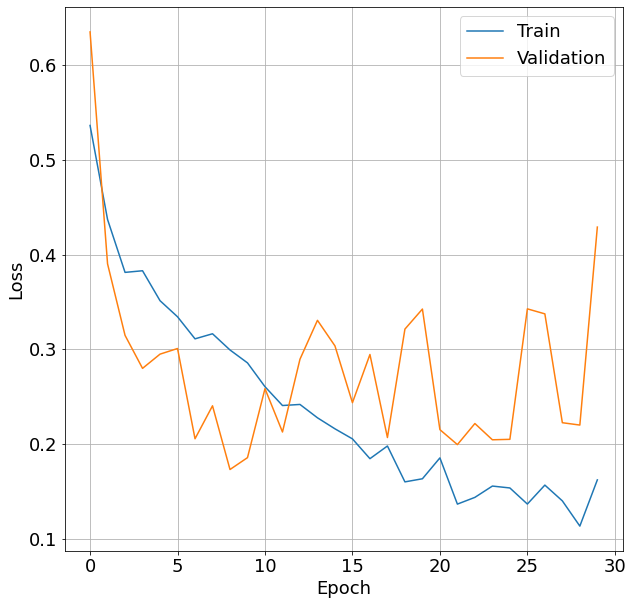

In [234]:
plot_dict = {}

plot_dict["Train"] = trainLosses
plot_dict["Validation"] = valLosses
plot_dict["ylabel"] = "Loss"

plot_train_val(**plot_dict)


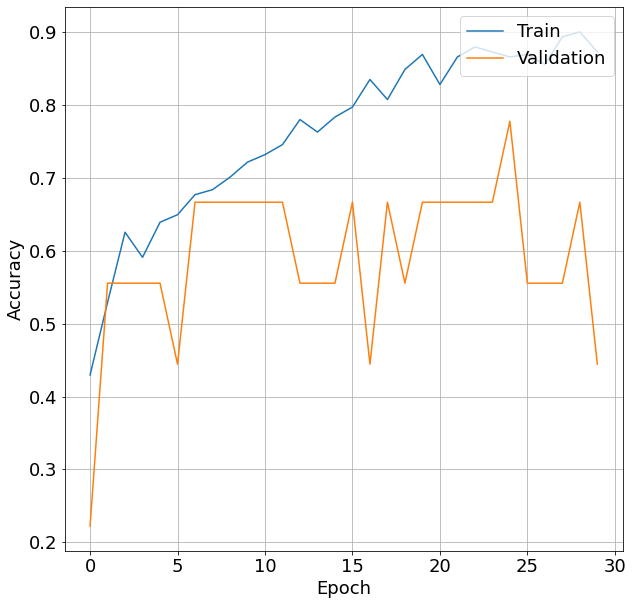

In [235]:
plot_dict["Train"] = trainAccs
plot_dict["Validation"] = valAccs
plot_dict["ylabel"] = "Accuracy"

plot_train_val(**plot_dict)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


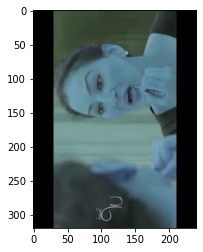

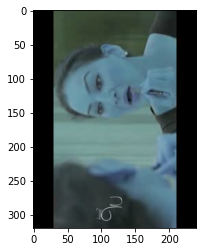

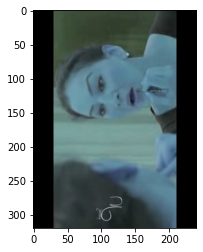

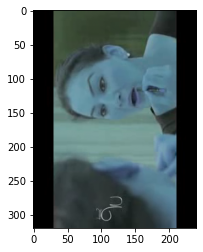

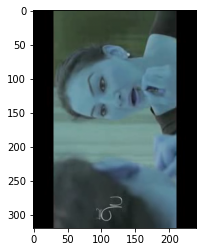

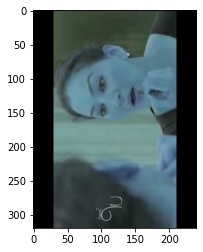

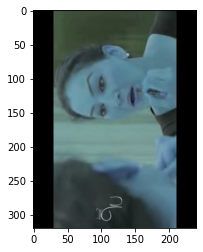

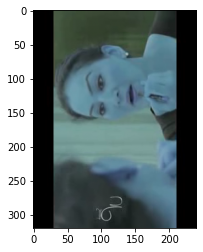

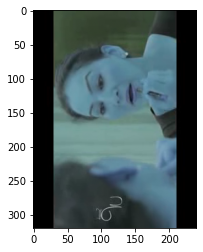

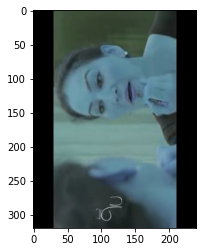

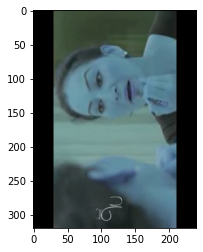

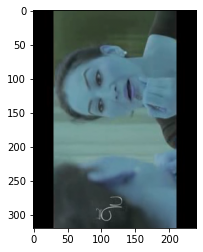

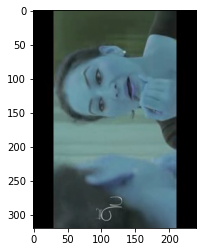

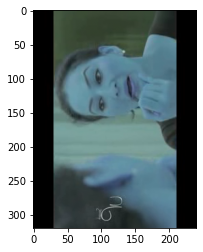

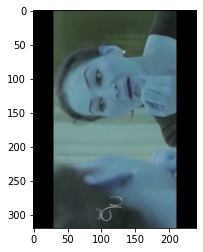

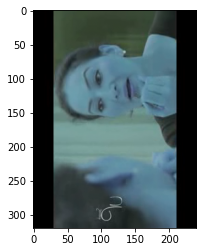

In [232]:
n = 100
for i in range(dataStorage.trainData[n].shape[0]):
    fig, ax = plt.subplots()
    ax.imshow(np.swapaxes(dataStorage.trainData[n][i], 0, 2) / 255.)
    print(dataStorage.trainLabels[n])

In [10]:
model = AdvancedTimeSformer(
    dim = tsf_dim,
    image_width = 320,
    image_height = 240,
    patch_size = tsf_patch_size,
    num_frames = framesPerVideo,
    num_classes = embeddingsSize,
    depth = tsf_depth,
    heads = tsf_heads,
    dim_head = tsf_dim_head,
    attn_dropout = 0.1,
    ff_dropout = 0.1
)

NameError: name 'tsf_dim' is not defined

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.device_count())

if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model, device_ids=[i for i in range(torch.cuda.device_count())])
model.to(device)

cuda
1


Transformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=16, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=16, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=16, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_featu

In [13]:
lossFunc = torch.nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters())

In [14]:
def getTripletsForBatch(batchIndices, isTrain = True):
    posClassIndices = []
    for b in batchIndices:
        if isTrain:
            index = random.randint(0, len(dataStorage.trainDict[dataStorage.trainLabels[b]]) - 2)
            elem = dataStorage.trainDict[dataStorage.trainLabels[b]][index]
            if elem >= b:
                elem = dataStorage.trainDict[dataStorage.trainLabels[b]][index + 1]
            posClassIndices.append(elem)
        else:
            index = random.randint(0, len(dataStorage.testDict[dataStorage.testLabels[b]]) - 2)
            elem = dataStorage.testDict[dataStorage.testLabels[b]][index]
            if elem >= b:
                elem = dataStorage.testDict[dataStorage.testLabels[b]][index + 1]
            posClassIndices.append(elem)
    negClassIndices = []
    for b in batchIndices:
        if isTrain:
            classNum = random.randint(0, len(dataStorage.trainDict.keys()) - 2)
            if classNum >= dataStorage.trainLabels[b]:
                classNum += 1
            index = random.randint(0, len(dataStorage.trainDict[classNum]) - 1)
            negClassIndices.append(dataStorage.trainDict[classNum][index])
        else:
            classNum = random.randint(0, len(dataStorage.testDict.keys()) - 2)
            if classNum >= dataStorage.testLabels[b]:
                classNum += 1
            index = random.randint(0, len(dataStorage.testDict[classNum]) - 1)
            negClassIndices.append(dataStorage.testDict[classNum][index])
            
    return batchIndices + posClassIndices + negClassIndices

In [15]:
print('Learnable params: ' + str(sum(p.numel() for p in model.parameters() if p.requires_grad)))

trainAccs = []
trainLosses = []
valAccs = []
valLosses = []

for epoch in range(numEpochs):  # loop over the dataset multiple times
    start_time = time.time()
    indices = [i for i in range(len(dataStorage.trainData))]
    random.shuffle(indices)
    
    #Train
    print('Start training')
    model.train()
    train_correct = 0
    train_loss = 0.0
    for batchNumber in range(len(dataStorage.trainData) // batchSize):
        batchIndices = getTripletsForBatch(indices[batchNumber * batchSize : (batchNumber + 1) * batchSize])
        
        inputs = torch.tensor([dataStorage.trainData[i] for i in batchIndices], dtype = torch.float32)
        inputs = inputs.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = lossFunc(outputs[:batchSize], outputs[batchSize:2*batchSize], outputs[2*batchSize:])
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        for i in range(batchSize):
            if torch.dist(outputs[i], outputs[batchSize + i]) < torch.dist(outputs[batchSize + i], outputs[2 * batchSize + i]):
                train_correct += 1
        
        del inputs
        del outputs

    indices = [i for i in range(len(dataStorage.testData))]
    random.shuffle(indices)
    
    print('Epoch: %d Batches: %d Train loss: %.3f Train acc: %.3f' %
          (epoch + 1, len(dataStorage.trainData) // batchSize, train_loss / len(dataStorage.trainData), train_correct / len(dataStorage.trainData)))
    trainAccs.append(train_correct / len(dataStorage.trainData))
    trainLosses.append(train_loss / len(dataStorage.trainData))

    #Validation
    print('Start validation')
    model.train(False)
    val_correct = 0
    val_loss = 0.0
    for batchNumber in range(len(dataStorage.testData) // batchSize):
        batchIndices = getTripletsForBatch(indices[batchNumber * batchSize : (batchNumber + 1) * batchSize], isTrain=False)
        
        inputs = torch.tensor([dataStorage.testData[i] for i in batchIndices], dtype = torch.float)
        inputs = inputs.to(device)
        
        outputs = model(inputs)
        loss = lossFunc(outputs[:batchSize], outputs[batchSize:2*batchSize], outputs[2*batchSize:])

        val_loss += loss.item()
        
        for i in range(batchSize):
            if torch.dist(outputs[i], outputs[batchSize + i]) < torch.dist(outputs[batchSize + i], outputs[2 * batchSize + i]):
                val_correct += 1
                
        del inputs
        del outputs
    
    print('Epoch: %d Val loss: %.3f Val acc: %.3f' %
          (epoch + 1, val_loss / len(dataStorage.testData), val_correct / len(dataStorage.testData)))
    valAccs.append(val_correct / len(dataStorage.testData))
    valLosses.append(val_loss / len(dataStorage.testData))
    
    print("%s seconds for epoch" % (time.time() - start_time))

print('Finished Training')

torch.save(model, "timesformerOnUCFSiamese")

Learnable params: 329152
Start training


TypeError: forward() missing 1 required positional argument: 'tgt'

In [60]:
print(dataStorage.testDict)

defaultdict(<class 'list'>, {0: [0, 1, 2], 1: [3, 4, 5], 2: [6, 7, 8], 3: [9, 10, 11]})


In [9]:
model.load_state_dict(torch.load('timesformerOnUcf_256_16_6_8_32'), strict=False)

NameError: name 'model' is not defined

In [13]:
model = torch.load('model_3ce')

C:\Users\Alexander\.conda\envs\torch\lib\site-packages\torch\serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.parallel.data_parallel.DataParallel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\Alexander\.conda\envs\torch\lib\site-packages\torch\serialization.py:625: UserWarning: Couldn't retrieve source code for container of type AdvancedTimeSformer. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
C:\Users\Alexander\.conda\envs\torch\lib\site-packages\torch\serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the pa

In [14]:
model.eval()
model = model.module
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.device_count())

if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model, device_ids=[i for i in range(torch.cuda.device_count())])
model.to(device)

cuda
1


AdvancedTimeSformer(
  (to_patch_embedding): Linear(in_features=768, out_features=128, bias=True)
  (pos_emb): Embedding(2401, 128)
  (layers): ModuleList(
    (0): ModuleList(
      (0): PreNorm(
        (fn): Attention(
          (to_qkv): Linear(in_features=128, out_features=384, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=128, out_features=128, bias=True)
            (1): Dropout(p=0.1, inplace=False)
          )
        )
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (1): PreNorm(
        (fn): Attention(
          (to_qkv): Linear(in_features=128, out_features=384, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=128, out_features=128, bias=True)
            (1): Dropout(p=0.1, inplace=False)
          )
        )
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (2): PreNorm(
        (fn): FeedForward(
          (net): Sequential(
           

In [31]:
'''val_correct = 0

indices = [i for i in range(len(dataStorage.testData))]

for batchNumber in range(len(dataStorage.testData) // batchSize):
    batchIndices = getTripletsForBatch(indices[batchNumber * batchSize : (batchNumber + 1) * batchSize], isTrain=False)

    inputs = torch.tensor([dataStorage.testData[i] for i in batchIndices], dtype = torch.float)
    inputs = inputs.to(device)

    outputs = model(inputs)

    for i in range(batchSize):
        if torch.dist(outputs[i], outputs[batchSize + i]) < torch.dist(outputs[batchSize + i], outputs[2 * batchSize + i]):
            val_correct += 1
    print(val_correct)

    del inputs
    del outputs
    
print(val_correct)'''

0


In [35]:
indices = [i for i in range(len(dataStorage.testData))]

correctPreds = 0
allPreds = 0

for batchNumber in range(len(dataStorage.testData) // batchSize):
    inputs = torch.tensor([dataStorage.testData[i] for i in indices[batchNumber * batchSize : (batchNumber + 1) * batchSize]], dtype = torch.float)
    labels = [dataStorage.testLabels[i] for i in indices[batchNumber * batchSize : (batchNumber + 1) * batchSize]]
    inputs = inputs.to(device)

    outputs = model(inputs)
    outputs = outputs.cpu().detach().numpy()
    allPreds += len(labels)
    correctPreds += len([i for i in range(len(labels)) if outputs[i][labels[i]] == max(outputs[i])])
    print(correctPreds / allPreds)

print(correctPreds / allPreds)

0.0
0.0
0.0
0.0
0.0
0.0
0.14285714285714285
0.125
0.1111111111111111
0.1
0.09090909090909091
0.08333333333333333
0.07692307692307693
0.07142857142857142
0.06666666666666667
0.0625
0.058823529411764705
0.05555555555555555
0.05263157894736842
0.05
0.047619047619047616
0.045454545454545456
0.043478260869565216
0.041666666666666664
0.04
0.038461538461538464
0.037037037037037035
0.03571428571428571
0.034482758620689655
0.03333333333333333
0.03225806451612903
0.03125
0.030303030303030304
0.029411764705882353
0.02857142857142857
0.027777777777777776
0.05405405405405406
0.05263157894736842
0.05128205128205128
0.05
0.04878048780487805
0.047619047619047616
0.046511627906976744
0.06818181818181818
0.06666666666666667
0.06521739130434782
0.06382978723404255
0.0625
0.061224489795918366
0.06
0.0784313725490196
0.09615384615384616
0.09433962264150944
0.09259259259259259
0.10909090909090909
0.125
0.12280701754385964
0.13793103448275862
0.15254237288135594
0.16666666666666666
0.16393442622950818
0.1612

0.30580357142857145
0.3051224944320713
0.30444444444444446
0.30376940133037694
0.3030973451327434
0.30242825607064017
0.30176211453744495
0.3010989010989011
0.30043859649122806
0.29978118161925604
0.29912663755458513
0.2984749455337691
0.29782608695652174
0.29718004338394793
0.29653679653679654
0.2958963282937365
0.2952586206896552
0.2946236559139785
0.2939914163090129
0.29336188436830835
0.29273504273504275
0.2921108742004264
0.29148936170212764
0.2908704883227176
0.2902542372881356
0.28964059196617337
0.2890295358649789
0.28842105263157897
0.28781512605042014
0.28721174004192873
0.28661087866108786
0.2860125260960334
0.28541666666666665
0.28482328482328484
0.2842323651452282
0.2836438923395445
0.2830578512396694
0.2824742268041237
0.28189300411522633
0.28336755646817247
0.2827868852459016
0.2822085889570552
0.2816326530612245
0.28105906313645623
0.2804878048780488
0.2799188640973631
0.2793522267206478
0.2808080808080808
0.28225806451612906
0.2837022132796781
0.285140562248996
0.28657

0.2377142857142857
0.23858447488584475
0.2394526795895097
0.23917995444191345
0.24004550625711035
0.2409090909090909
0.24063564131668558
0.24036281179138322
0.24009060022650056
0.2398190045248869
0.23954802259887006
0.23927765237020315
0.23900789177001128
0.23873873873873874
0.23847019122609675
0.23820224719101124
0.23793490460157127
0.23766816143497757
0.23852183650615902
0.23825503355704697
0.23798882681564246
0.23772321428571427
0.23745819397993312
0.23719376391982183
0.23692992213570635
0.23666666666666666
0.23640399556048836
0.2361419068736142
0.23588039867109634
0.23561946902654868
0.23535911602209944
0.23509933774834438
0.2348401323042999
0.23458149779735682
0.23432343234323433
0.23516483516483516
0.2349066959385291
0.23464912280701755
0.2343921139101862
0.23413566739606126
0.23387978142076501
0.2336244541484716
0.23336968375136313
0.23311546840958605
0.23286180631120784
0.2326086956521739
0.23235613463626492
0.23210412147505424
0.23185265438786565
0.23160173160173161
0.23135135